In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a FourFeature model that has the same basic structure as the TwoFeature 6 convolutional layer  model. The differences/similarlities are:

  [1]  the FourFeature model has four channels of input rather than two.
  [2]  the extra two channels are added by using load_xy=True in collect_data (x2)
  [3]  the pretrained_dict is used with strict=False
  
In the first iterations, the weights from a trained TwoFeature_CNN6Layer_A model should be reused for the (X,Xsq) part of the algorithm, and the algorithm should only learn the filter for the (perturbative) (x,y) features.
  
Once the perturbative filters are beng generated, the algorithm can start with weights from a previous iteration of this algorithm and all weights free to float.

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Mon Oct 12 00:05:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 5

# Name is the output file name


##  190810  mds
folder = '11Oct2010_LHCb'
name = '11Oct2020_LHCb'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_E import FourFeature_CNN6Layer_D as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('dataAA/Aug14_80K_train.h5',
##                            'dataAA/Oct03_80K_train.h5',
##                            'dataA/Oct03_80K2_train.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

Loading data...
Loaded dataAA/Aug14_80K_train.h5 in 22.4 s
Constructing 80000 event dataset took 0.5493 s


In [10]:
# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokolnotebooks/RunModel_Demo_17May2020.ipynboff/ML-data_AA/
## mds val_loader = collect_data('dataAA/Oct03_20K_val.
##  1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 has events with
## both original KDEs and new posca KDEs
## how this is read depends on the source of collect_data
val_loader = collect_data('dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5',
##val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',
##val_loader = collect_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                          batch_size=batch_size,
                          slice=slice(256 * 39),
##                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)
"""

val_loader = collect_data('dataAA/Oct03_20K_val.h5',
                          batch_size=batch_size,
                          slice=slice(256 * 39),
##                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)
"""

Loading data...
Loaded dataAA/HLT1CPU_1kevts_val.h5 in 0.2403 s
Constructing 941 event dataset took 0.007956 s


"\n\nval_loader = collect_data('dataAA/Oct03_20K_val.h5',\n                          batch_size=batch_size,\n                          slice=slice(256 * 39),\n##                          device=device,\n                          masking=True, shuffle=False,\n                          load_XandXsq=True,\n                          load_xy=True)\n"

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=4.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
ct, child =  6    Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  7    Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  8    Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  9    Linear(in_features=4000, out_features=4000, bias=True)
ct, child =  10    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
ct, child =  11    Dropout(p=0.15, inplace=False)
ct, child =  12    Dropout(p=0.15, inplace=False)
ct, child =  13    Dropout(p=0.15, inplace=F

In [12]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
##pretrained_dict = torch.load('ML/Aug17_FourFeature_CNN6LayerPlus_TargetsAA_Loss_A_1p0_final.pyt')
##pretrained_dict = torch.load('ML/Aug18_FourFeature_CNN6LayerPlus_TargetsAA_First400epochs_160K_lr_3em4_bs128_Alt_Loss_A_0p0/Aug18_FourFeature_CNN6LayerPlus_TargetsAA_First400epochs_160K_lr_3em4_bs128_Alt_Loss_A_0p0_final.pyt')
pretrained_dict = torch.load('ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/11Oct2010_LHCb
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4of6.weight
index, k =   7    conv4of6.bias
index, k =   8    conv5of6.weight
index, k =   9    conv5of6.bias
index, k =   10    finalFilter.weight
index, k =   11    finalFilter.bias
index, k =   12    ppConv1.weight
index, k =   13    ppConv1.bias
index, k =   14    ppConv2.weight
index, k =   15    ppConv2.bias
index, k =   16    ppConv3.weight
index, k =   17    ppConv3.bias
index, k =   18    ppFc1.weight
index, k =   19    ppFc1.bias
index, k =   20    ppFinalFilter.weight
index, k =   21    ppFinalFilter.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4of6.w

<All keys matched successfully>

In [14]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


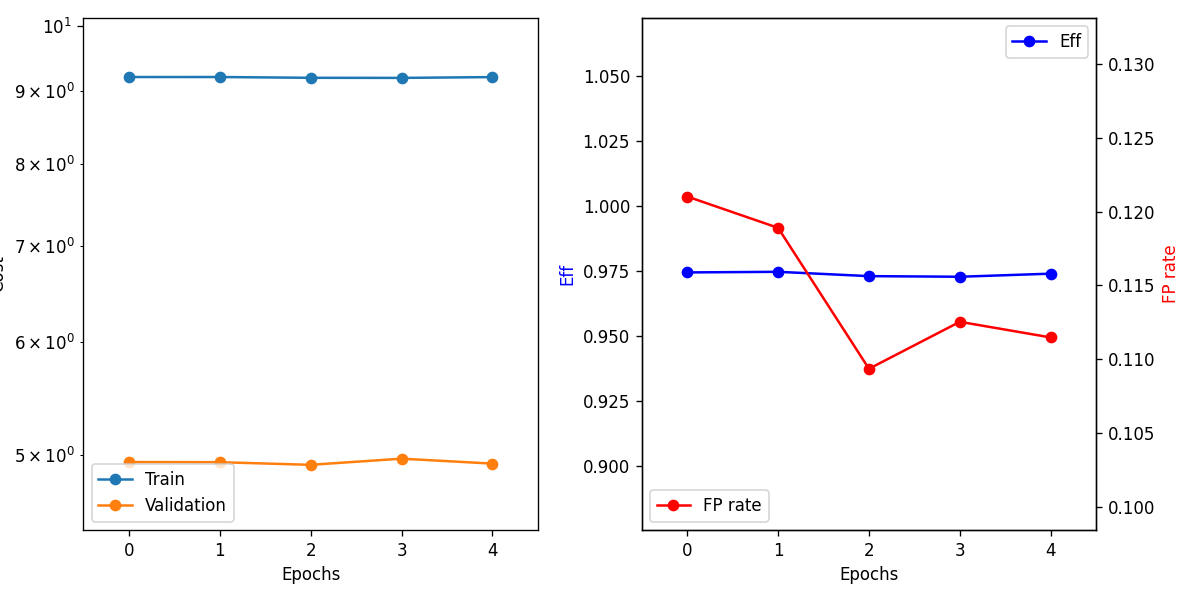

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 625, val = 8


Epoch 0: train=9.20197, val=4.94092, took 22.679 s
  Validation Found 4110 of 4218, added 114 (eff 97.44%) (0.121 FP/event)


Epoch 1: train=9.20216, val=4.93994, took 24.433 s
  Validation Found 4111 of 4218, added 112 (eff 97.46%) (0.119 FP/event)


Epoch 2: train=9.19045, val=4.91909, took 21.996 s
  Validation Found 4104 of 4218, added 103 (eff 97.30%) (0.109 FP/event)


Epoch 3: train=9.18915, val=4.96827, took 21.245 s
  Validation Found 4103 of 4218, added 106 (eff 97.27%) (0.113 FP/event)


Epoch 4: train=9.20106, val=4.92872, took 21.216 s
  Validation Found 4108 of 4218, added 105 (eff 97.39%) (0.111 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [17]:
##torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
##results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


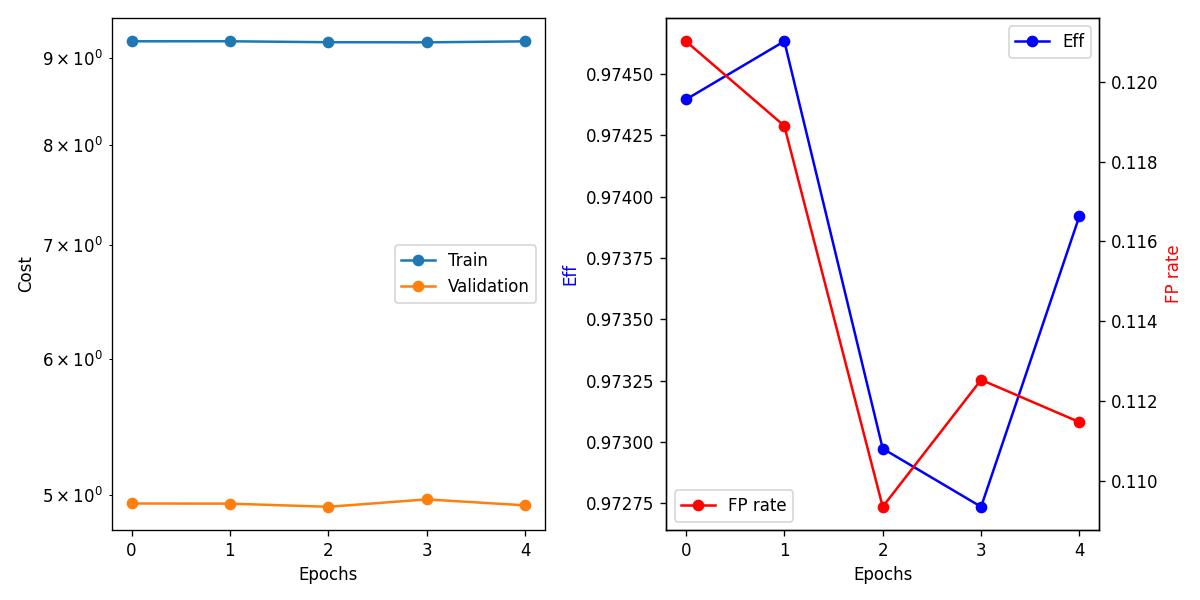

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [20]:
quit()